# Analysis of Nanocamp Science Identity Construct

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

import re

# Read in compiled surveys from both camps

In [2]:
gearup = pd.read_excel('Data/GEAR UP Nanocamp Survey.xlsx')
gearup.set_index('Student ID', inplace=True)

conted = pd.read_excel('Data/Cont Ed Nanocamp Survey.xlsx')
conted.set_index('Student ID', inplace=True)

# Parse results into numerical values.
Each camp is save as a dictionary, with the question as keys and the results for both pre and post sruveys as a multidimensional array.

In [7]:
answer_map = {'strongly disagree': 1, 'disagree': 2, 'neither agree nor disagree': 3, 'neither': 3,
              'agree': 4, 'strongly agree': 5, np.nan: 0}

DATA = []
for df in [gearup, conted]:
    questions = df.columns
    data = {re.findall(r'\[.*?\]', q)[0]: [] for q in questions if 'A [' in q}
    N = len(data)

    for i, q in enumerate(questions):
        if 'A [' in q or 'B [' in q:
            question = list(data.keys())[i % N]
            answers = np.array([answer_map[str(x).lower()] if x is not np.nan else answer_map[np.nan]
                                for x in df.iloc[:, i] ])
            data[question].append(answers)
    DATA.append(data)

# Visualize Results

In [5]:
def plot_by_question(data_dict, mode='line', camp='gear_up'):
    ncols = 4
    N = len(data_dict)
    nrows = N // ncols + 1
    fig, axes = plt.subplots(figsize=(ncols * 4, 4 * nrows), ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    
    if camp == 'gearup':
        colors = [plt.cm.tab20b(17), plt.cm.tab20b(16), plt.cm.tab20b(19)]
    else:
        colors = [plt.cm.tab20b(13), plt.cm.tab20b(12), plt.cm.tab20b(15)]

    for i in range(int(ncols * nrows)):
        row, colm = np.unravel_index(i, (nrows, ncols))
        if i >= N:
            axes[row, colm].axis('off')
        else:
            q = list(data_dict.keys())[i]
            data = np.array(data_dict[q])

            nan_indices = np.where(data == 0)
            cols = np.flip(np.sort(np.array(nan_indices).T[:, 1]))
            for col in cols:
                data = np.delete(data, col, axis=1)

            if mode == 'line':
                axes[row, colm].plot(data, c=colors[0], alpha=0.25, linewidth=4)
                dx = 0
                axes[row, colm].set_xlim(dx + -0.2, dx + 1.2)
            else:
                axes[row, colm].boxplot(data, patch_artist=True,
                                        medianprops=dict(color=colors[1], linewidth=3),
                                        boxprops=dict(facecolor=colors[2]))
                dx = 1
                axes[row, colm].set_xlim(dx + -0.4, dx + 1.4)

            question = q.replace('[', '').replace(']', '')
            if ',' in question:
                question = question.replace(', ', ',\n')
            elif len(question) > 30:
                split = question.split(' ')
                n = len(split)
                question = ' '.join(split[:n // 2 + 1]) + '\n' + ' '.join(split[n // 2 + 1:])

            axes[row, colm].set_ylabel(question, fontsize=14)
            axes[row, colm].set_yticks(np.arange(6))
            axes[row, colm].set_xticks([dx + 0, dx + 1])
            axes[row, colm].set_xticklabels(['Before', 'After'])
            axes[row, colm].set_ylim(0.8, 5.2)
            axes[row, colm].tick_params(width=2, length=6, labelsize=16)

    plt.savefig(f'Figures/before_vs_after_{mode}_{camp}.png', dpi=800, bbox_inches='tight')

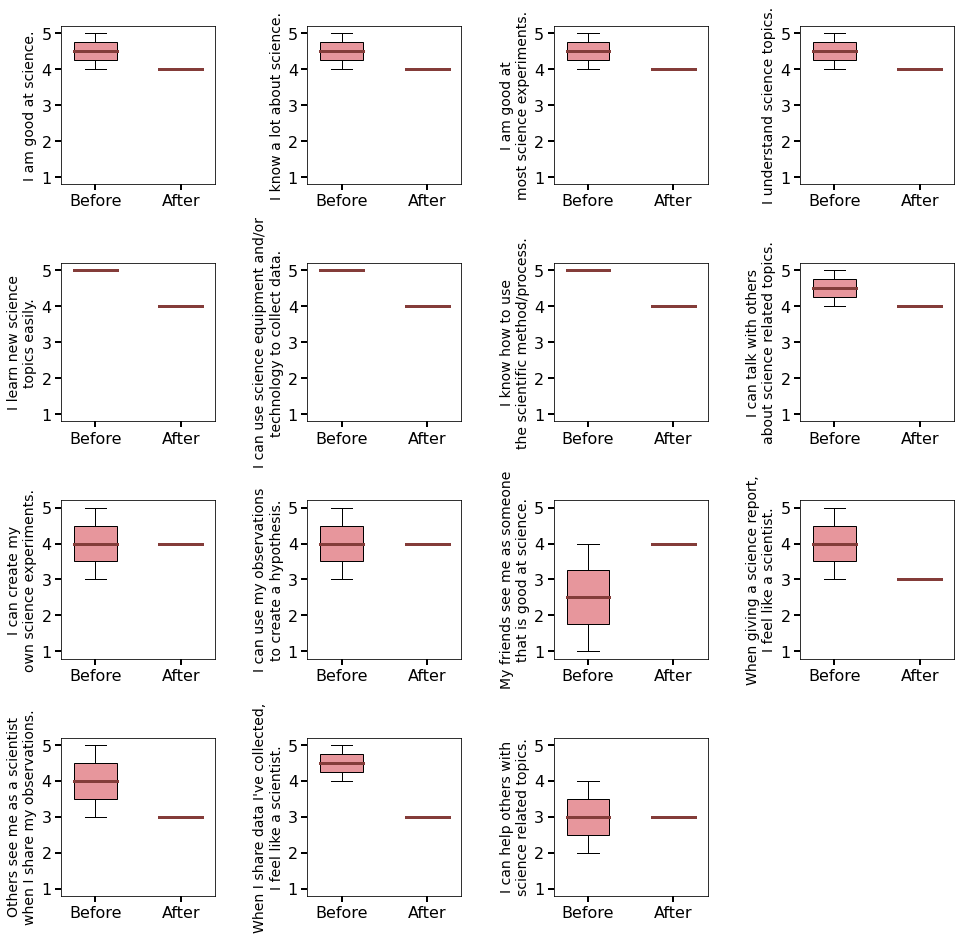

In [9]:
for i, camp in enumerate(['gearup', 'conted']):
    if camp == 'conted':
        plot_by_question(DATA[i], mode='boxplot', camp=camp)
        #plot_by_question(DATA[i], mode='line', camp=camp)